In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib as mp
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

from config import DB_NAME,PASSWORD,UNAME,MYHOST

try :
    con = psycopg2.connect(dbname=DB_NAME, host=MYHOST,password=PASSWORD,user=UNAME)
except:
    raise
cur = con.cursor()

In [111]:
"""
Pre Declare Some Variables
"""

columns = ["body_polarity","body_subjectivity","body_othref","body_time","body_inhib","body_space","body_posemo",  
           "body_self","body_social","body_humans","body_sports","body_other","body_music","body_swear","body_discrep",
           "body_nonfl","body_you","body_cause","body_sexual","body_achieve","body_relig","body_cogmech","body_we",
           "body_senses","body_eating","body_optim","body_incl","body_leisure","body_job","body_hear","body_preps",
           "body_affect","body_excl","body_home","body_friends","body_present","body_body","body_school","body_comm",
           "body_physcal","body_i","body_groom","body_tentat","body_up","body_motion","body_negate",
           "body_future","body_death","body_article","body_fillers","body_family","body_pronoun","body_metaph",
           "body_feel","body_certain","body_insight","body_assent","body_number","body_sad","body_past","body_down",
           "body_see","body_tv","body_sleep","body_money","body_anger","body_posfeel","body_anx","body_negemo",
           "body_occup"]

In [61]:
"""
Get a list of unique sub reddits from comments table
"""
statement = 'SELECT DISTINCT subreddit FROM comments'
cur.execute(statement)
sub_reddits = cur.fetchall()
sub_reddits = [x[0] for x in sub_reddits]

In [62]:
"""
How many total comments in each sub?
"""
num_comments = {}

for sub in sub_reddits:    
    statement = 'SELECT body_anger FROM comments WHERE subreddit = \'' +sub+'\''
    cur.execute(statement)
    data = cur.fetchall()
    data = [x[0] for x in data]
    num_comments[sub] = len(data)


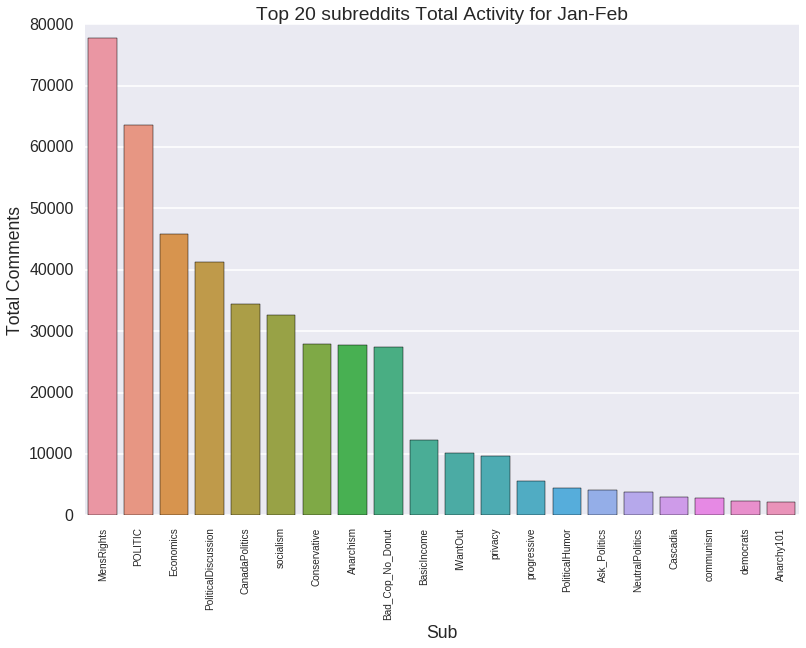

In [63]:
comments = pd.DataFrame(num_comments.items(),columns=['Sub','Comments'])
comments = comments.sort_values('Comments',ascending=False)
comments.head()

sns.set_context("poster")

plot = sns.barplot(x = "Sub" , y = "Comments", data = comments.head(n=20))
plot.set(xlabel="Sub", ylabel="Total Comments",title="Top 20 subreddits Total Activity for Jan-Feb")
for l in plot.get_xticklabels():
    l.set_rotation(90)
    l.set_fontsize(10)

In [65]:
"""
Lets Just Filter for Everything Bigger than 5000 comments
"""

subs_to_keep = comments.query('Comments >= 5000')['Sub'].tolist()


print subs_to_keep


['MensRights', 'POLITIC', 'Economics', 'PoliticalDiscussion', 'CanadaPolitics', 'socialism', 'Conservative', 'Anarchism', 'Bad_Cop_No_Donut', 'BasicIncome', 'IWantOut', 'privacy', 'progressive']


In [66]:
anger_dict = {}
for sub in subs_to_keep:    
    statement = 'SELECT * FROM comments WHERE subreddit = \'' +sub+'\' AND parent_id LIKE \'t1_%\' AND author != \'[deleted]\' '
    df = pd.read_sql(statement,con)
    data = cur.fetchall()
    data = [x[0] for x in data]
    anger_dict[sub] = data
    break

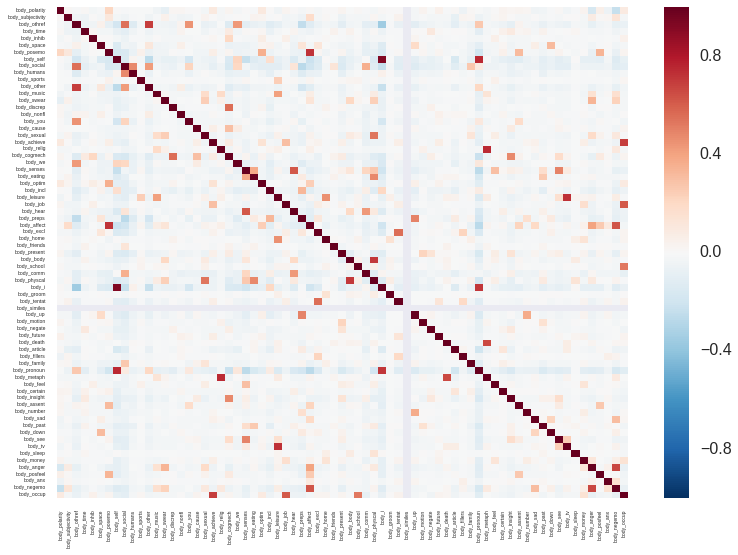

In [67]:
"""
Let's Look for Correlated measures!
"""
from random import randint
import random
sns.set_context("poster")
random.seed(8675309)
pair_correlations = df.loc[:,columns].corr()
plot=sns.heatmap(pair_correlations)
plot.tick_params(labelsize=5)

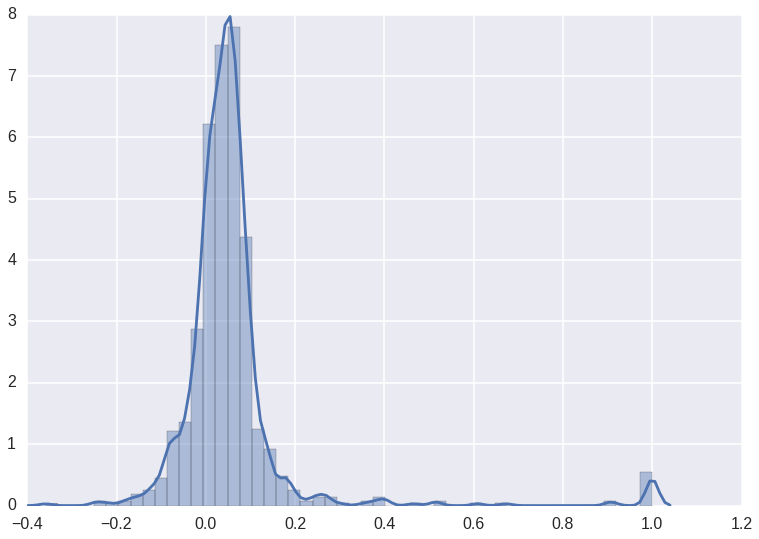

In [68]:
max_index = len(columns)-1

permutations = []

sample = 1000
while sample != 0:
    
    vec1 = df[columns[randint(0,max_index)]]
    vec2 = df[columns[randint(0,max_index)]].reindex(np.random.permutation(df.index))
        
    correlation = vec1.corr(vec2,method="spearman")
    
    if not np.isnan(correlation):
        permutations.append(correlation)
        sample -=1
    
sns.distplot(permutations)

#sns.heatmap(pair_correlations)

In [69]:
import sklearn
this_df = df.loc[:,columns]

#Initialize our data frame
data_frame = {}
for k in columns:
    data_frame[k] = []
data_frame['total_negemo_response'] = []
data_frame['total_posemo_response'] = []
data_frame['total_anx_response'] = []
data_frame['total_anger_response'] = []
data_frame['total_sad_response'] = []
data_frame['total_certain_response'] = []
data_frame['total_swear_response'] = []
data_frame['total_assent_response'] = []
data_frame['total_responses']=[]


#Build it
for index,row in df.iterrows():
    others_parent_id = 't1_' + row['id']
    children = df[df.parent_id == others_parent_id]
    if not len(children)==0: #only want to train when I got responses
        for k in columns:
            data_frame[k].append(row[k])
        children_sum = children.apply(np.sum)
        data_frame['total_negemo_response'].append(children_sum["body_negemo"])
        data_frame['total_posemo_response'].append(children_sum["body_posemo"])
        data_frame['total_anx_response'].append(children_sum["body_anx"])
        data_frame['total_anger_response'].append(children_sum["body_anger"])
        data_frame['total_sad_response'].append(children_sum["body_sad"])
        data_frame['total_certain_response'].append(children_sum["body_certain"])
        data_frame['total_swear_response'].append(children_sum["body_swear"])
        data_frame['total_assent_response'].append(children_sum["body_assent"])
        data_frame['total_responses'].append(len(children))

In [82]:
#dict -> pandas

transformed_data = pd.DataFrame(data_frame)
#print(columns)

In [113]:
import random
total_anger_features = columns
#print(columns)
total_anger_features.remove('body_anger')
random.shuffle(total_anger_features)
print(total_anger_features)

['body_i', 'body_inhib', 'body_humans', 'body_number', 'body_subjectivity', 'body_negate', 'body_job', 'body_groom', 'body_othref', 'body_death', 'body_you', 'body_metaph', 'body_certain', 'body_down', 'body_sleep', 'body_other', 'body_discrep', 'body_cogmech', 'body_sad', 'body_tentat', 'body_negemo', 'body_occup', 'body_friends', 'body_money', 'body_senses', 'body_school', 'body_space', 'body_polarity', 'body_time', 'body_fillers', 'body_assent', 'body_body', 'body_affect', 'body_we', 'body_relig', 'body_achieve', 'body_feel', 'body_past', 'body_self', 'body_pronoun', 'body_leisure', 'body_sexual', 'body_future', 'body_present', 'body_up', 'body_tv', 'body_posemo', 'body_excl', 'body_posfeel', 'body_incl', 'body_family', 'body_anx', 'body_physcal', 'body_sports', 'body_motion', 'body_insight', 'body_cause', 'body_optim', 'body_hear', 'body_preps', 'body_swear', 'body_social', 'body_eating', 'body_nonfl', 'body_home', 'body_comm', 'body_article', 'body_music', 'body_see']


In [122]:
X=transformed_data[total_anger_features].values
Y=transformed_data['total_anger_response'].values

train_X = scale(X[train_idx, :])
test_X  = scale(X[test_idx, :])

train_Y = Y[train_idx]
test_Y = Y[test_idx]

lr = sklearn.ensemble.RandomForestRegressor(n_jobs=8)
lr.fit(train_X,train_Y)

predicted = lr.predict(test_X)


score = lr.score(test_X,test_Y)
if score > best_score:
    best_score = score
    best_model = lr

In [52]:
import cPickle as pickle

with open('test.pickle','wb') as f:
    pickle.dump(best_model,f)
    
print(len(columns))

76


0.797396379271


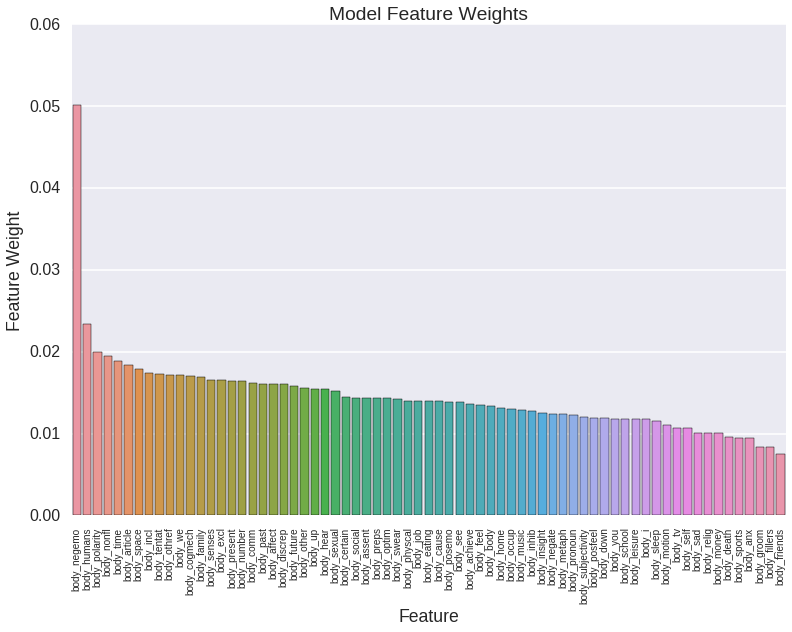

In [123]:
print(best_score)
features = sorted(zip(map(lambda x: round(x, 4), lr.feature_importances_), columns), 
             reverse=True)

features = pd.DataFrame.from_dict(features)
features.columns =['Weight','Feature']
features.head()

plot=sns.barplot(data=features, x='Feature',y='Weight')
plot.set(xlabel="Feature", ylabel="Feature Weight",title="Model Feature Weights")
for l in plot.get_xticklabels():
    l.set_rotation(90)
    l.set_fontsize(10)

(0, 0.25000000000000006)

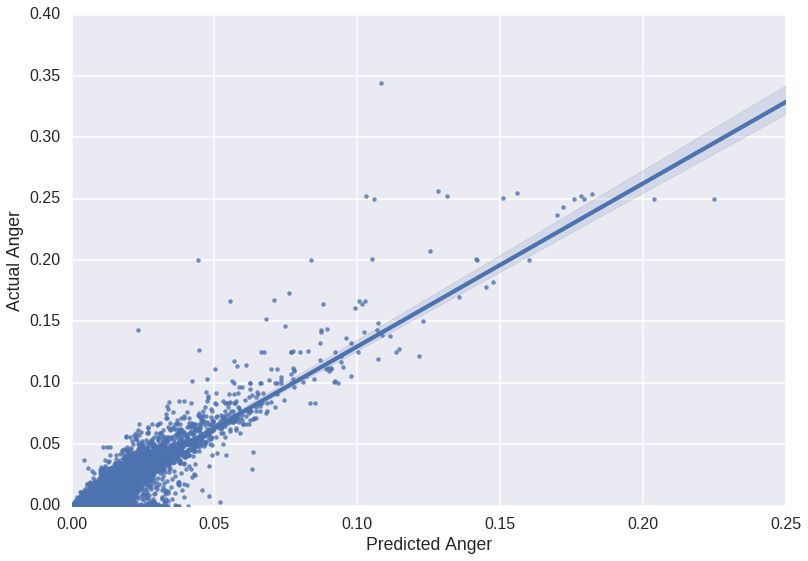

In [133]:
sns.regplot(predicted,test_Y,n_boot=1000, ci = 99.9 , label='R^2 = 0.81')
sns.axlabel("Predicted Anger","Actual Anger")
sns.plt.ylim(0,)
sns.plt.xlim(0,)

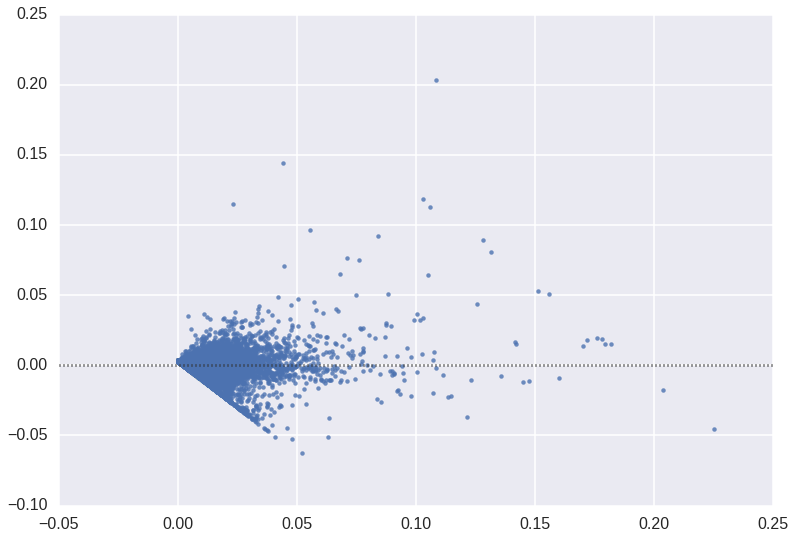

In [129]:
sns.residplot(predicted,test_Y)

ImportError: No module named plotly